In [1]:
import sys
import time
import random
import argparse
import math
import copy

from collections import defaultdict
import itertools

import numpy as np

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')

import scipy.stats as stats
from statistics import mean

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

ip = get_ipython()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/sherry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import argparse
import logging
import math
import time

import torch
import torch.nn as nn

# Utility modules are from (Gulordava et al. 2018)
# https://github.com/facebookresearch/colorlessgreenRNNs/tree/master/src/language_models
from dictionary_corpus import Corpus
from lm_argparser import lm_parser
from utils import repackage_hidden, get_batch, batchify
import data

# Model file is from (Lakretz et al. 2019)
# Replace forward function to get hidden/cell/gates informaion
# https://github.com/FAIRNS/Number_and_syntax_units_in_LSTM_LMs/tree/master/Code
import model
import lstm

parser = argparse.ArgumentParser(parents=[lm_parser],
                                 description="Basic training and evaluation for RNN LM")

# Reload Model and Vocab


In [3]:
# Reload the model
model_pretrained = torch.load('hidden650_batch128_dropout0.2_lr20.0.pt', map_location=torch.device('cpu'))
model_pretrained.eval()

print("Model's state_dict:")
for param_tensor in model_pretrained.state_dict():
    print(param_tensor, "\t", model_pretrained.state_dict()[param_tensor].size())

# replace forward function to get hidden/cell/gates informaion    
model_pretrained.rnn.forward = lambda input, hidden: lstm.forward(model_pretrained.rnn, input, hidden)

model_orig_state = copy.deepcopy(model_pretrained.state_dict())

vocab = data.Dictionary('./data/vocab.txt')


Model's state_dict:
encoder.weight 	 torch.Size([50001, 650])
rnn.weight_ih_l0 	 torch.Size([2600, 650])
rnn.weight_hh_l0 	 torch.Size([2600, 650])
rnn.bias_ih_l0 	 torch.Size([2600])
rnn.bias_hh_l0 	 torch.Size([2600])
rnn.weight_ih_l1 	 torch.Size([2600, 650])
rnn.weight_hh_l1 	 torch.Size([2600, 650])
rnn.bias_ih_l1 	 torch.Size([2600])
rnn.bias_hh_l1 	 torch.Size([2600])
decoder.weight 	 torch.Size([50001, 650])
decoder.bias 	 torch.Size([50001])


# Single cell activation's mean & std

(averaged by chapters to prevent crash)

In [4]:
def get_hidden(word_token, model, hidden_init):
    criterion = nn.CrossEntropyLoss()
    cell = np.zeros((len(word_token),model.nhid*model.nlayers))
    hidden = hidden_init
    for j, w in enumerate(word_token):
        if w not in vocab.word2idx:
            w = '<unk>'
    
        inp = torch.autograd.Variable(torch.LongTensor([[vocab.word2idx[w]]]))
        out, hidden = model(inp, hidden)
        out = torch.nn.functional.log_softmax(out[0]).unsqueeze(0)
        
        cell[j,:] = hidden[1].data.view(-1).cpu().numpy()
        
    return cell

def load_novel_chapter(doShuffling=False):
    chunks = []
    with open('./data/anna.txt', "r") as inFile:
        for line in inFile:
            if line[:7] == "Chapter":
                yield "".join(chunks)
                chunks = []
            line_alpha=''.join(e for e in line)
            chunks.append(line_alpha.rstrip()+' ')
    yield "".join(chunks)

In [5]:
novel_chunks = load_novel_chapter()
novel_chunks = list(novel_chunks)

In [ ]:
# Run the whole novel and average over chapters
mean=[]
std=[]
init_h= model_pretrained.init_hidden(1) 
for i in range(len(novel_chunks)):
    print(i)
    novel_words=word_tokenize(novel_chunks[i])
    cell_intact= get_hidden(novel_words, model_pretrained, init_h)
    mean.append(np.mean(cell_intact,0))
    std.append(np.std(cell_intact,0))

In [6]:
# Or load the pre-run mean and std
cell_mean_activation=np.load('./activations/wlstm/anna_cell_activation_mean.npy')
cell_std_activation=np.load('./activations/wlstm/anna_cell_activation_std.npy')

# Helper Methods

In [7]:
# initial sentence that "warms up" the model 

def feed_sentence(model, h, sentence):
    outs = []
    for w in sentence:
        out, h = feed_input(model, h, w)
        outs.append(torch.nn.functional.log_softmax(out[0]).unsqueeze(0))
    return outs, h

def feed_input(model, hidden, w):
    if w not in vocab.word2idx:
        print('unk word: ' + w)
        w = '<unk>'
    inp = torch.autograd.Variable(torch.LongTensor([[vocab.word2idx[w]]]))
    out, hidden = model(inp, hidden)
    return out, hidden

# Sample text from novel
init_sentence = " ".join(["He read the letters. One was very unpleasant, from a merchant who was \
buying a forest on his wife's property. To sell this forest was absolutely essential; but at present, \
until he was reconciled with his wife, the subject could not be discussed. The most unpleasant thing of \
all was that his pecuniary interests should in this way enter into the question of his reconciliation with \
his wife. And the idea that he might be led on by his interests, that he might seek a reconciliation with his \
wife on account of the sale of the forest--that idea hurt him."])

hidden = model_pretrained.init_hidden(1)
init_sentence = word_tokenize(init_sentence)
init_out, init_hidden = feed_sentence(model_pretrained, hidden, init_sentence)

In [8]:
# Forward function that returns gate units' dynamics and sentence perplexity
# Results of 2 LSTM layers are concatenated and returned together
def get_hidden_sent(sent, model, hidden_init, init_out):
    criterion = nn.CrossEntropyLoss()
    pp_all=np.array(0)
    hidden_sent = np.zeros((len(sent),model.nhid*model.nlayers))
    cell_sent = np.zeros((len(sent),model.nhid*model.nlayers))
    log_probabilities=np.zeros(len(sent))
    out = init_out[-1]
    hidden = hidden_init
    for j, w in enumerate(sent):
        if w not in vocab.word2idx:
            w = '<unk>'
        # target word's log prob
        log_probabilities[j] = out[0,0,vocab.word2idx[w]].data.item()
        inp = torch.autograd.Variable(torch.LongTensor([[vocab.word2idx[w]]]))
        out, hidden = model(inp, hidden)
        out = torch.nn.functional.log_softmax(out[0]).unsqueeze(0)
        
        hidden_sent[j,:] = hidden[0].data.view(-1).cpu().numpy() #resize as 1300 (650 for 1st layer + 650 for 2nd layer)
        cell_sent[j,:] = hidden[1].data.view(-1).cpu().numpy()
        # we can retrieve the gates thanks to the hacked function (Lakretz et al. 2019)
        gates_in = torch.cat([g['in'].data for g in model.rnn.last_gates],1).cpu().numpy()
        gates_forget = torch.cat([g['forget'].data for g in model.rnn.last_gates],1).cpu().numpy()
        gates_out = torch.cat([g['out'].data for g in model.rnn.last_gates],1).cpu().numpy()
        gates_c_tilde = torch.cat([g['c_tilde'].data for g in model.rnn.last_gates],1).cpu().numpy()

    pp_sent=np.exp(-log_probabilities.mean())
    return hidden_sent, cell_sent, pp_sent, gates_in, gates_forget, gates_out, gates_c_tilde

# Comma-And Context Construction (Novel)

## Select shared input, intact context, and scrambled context

In [9]:
def load_novel(file='./data/anna.txt'):
    text = ''
    with open(file, "r") as inFile:
        for line in inFile:
            text = text + line.strip() + ' '
        return text

import re
def sent_word(sent):
    sent_word=[]
    for l in sent:
        sentence = word_tokenize(l)
        sent_word.append(sentence)
    return sent_word

In [10]:
# Hyperparameters

# Minimum length
CONTEXT_LENGTH = 10
SHARED_LENGTH = 25
VIEW_LENGTH = CONTEXT_LENGTH + SHARED_LENGTH
HIDDEN_DIM = model_pretrained.nhid*model_pretrained.nlayers

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

novel = load_novel('./data/anna.txt')
novel_sents = sent_tokenize(novel)

intact_context_sent = []
intact_shared_sent = []
target_punc=[', and ']
for line in novel_sents:
    if any(s in line for s in target_punc):
        # break sentence into context & input around ", and"
        segment = line.index(', and ')+1
        intact_context_sent.append(line[:segment-1])
        intact_shared_sent.append(line[segment-1:])
        
intact_context_words=sent_word(intact_context_sent)
intact_shared_words=sent_word(intact_shared_sent)

total_sents_num = len(intact_shared_words)

In [12]:
## select sentences with average PPL < 200, store the idx
input_pool_idx = [i for i in range(total_sents_num) if len(intact_shared_words[i])>=SHARED_LENGTH \
                  and len(intact_context_words[i])>=CONTEXT_LENGTH and all(w in vocab.word2idx for w in intact_shared_words[i]) and \
                  all(w in vocab.word2idx for w in intact_context_words[i])]

pp_intact_sents=[]
pp_idx=[]
for i in range(len(input_pool_idx)):
    idx = input_pool_idx[i]
    shared_input = intact_shared_words[idx][:SHARED_LENGTH]
    intact_context = intact_context_words[idx]
    intact_array = intact_context + shared_input
    _, _, pp_sent,_, _, _, _ = get_hidden_sent(intact_array, model_pretrained, init_hidden, init_out)
    if pp_sent<200:
        pp_intact_sents.append(pp_sent)
        pp_idx.append(input_pool_idx[i])

# select intact/scrambled context candidates
input_pool_idx = pp_idx

scamble_pool_idx = [i for i in range(total_sents_num) if i not in input_pool_idx and \
                    len(intact_context_words[i])>=CONTEXT_LENGTH and \
                    all(w in vocab.word2idx for w in intact_context_words[i])]

## Timescale Measurement

In [13]:
TRIAL_NUM = len(input_pool_idx) # number of intact sentences to examine
PERMU = 30 # number of scrambled context to compare against for each intact sentence

In [14]:
# Intact-random correlation of cell states (whole layer)  
# On each of the 2 layers separately
def pattern_correlation(shared_input, process_cntx_it, process_cntx_scram,
                        model, init_out): # chunk = preprocessed chars
    init_h = model_pretrained.init_hidden(1)
    
    intact_array = process_cntx_it + shared_input
    scrambled_array = process_cntx_scram + shared_input
    _, cell_intact, _, _, _, _, _ = get_hidden_sent(intact_array, model, init_h, init_out)
    _, cell_scrambled, _, _, _, _, _ = get_hidden_sent(scrambled_array, model, init_h, init_out)
    # Normalize activation
    cell_intact_norm=(cell_intact-cell_mean_activation)/cell_std_activation
    cell_scrambled_norm=(cell_scrambled-cell_mean_activation)/cell_std_activation

    intact_shared_idx = list(range(len(intact_array)))[-VIEW_LENGTH:]
    scrambled_shared_idx = list(range(len(scrambled_array)))[-VIEW_LENGTH:]
    corr_cell1 = np.zeros(0) # layer 1
    corr_cell2 = np.zeros(0) # layer 2
    for i in range(VIEW_LENGTH):
        idx1 = intact_shared_idx[i]
        idx2 = scrambled_shared_idx[i]
        corr1 = np.corrcoef(cell_intact_norm[idx1,:650], cell_scrambled_norm[idx2,:650])[0][1]
        corr2 = np.corrcoef(cell_intact_norm[idx1,650:], cell_scrambled_norm[idx2,650:])[0][1]
        corr_cell1 = np.append(corr_cell1, corr1)
        corr_cell2 = np.append(corr_cell2, corr2)
    return corr_cell1, corr_cell2

def construction_analysis(shared_input, process_cntx_it, process_cntx_scram,
                          model, init_out): # chunk = preprocessed chars
    # Feed in the entire context + head of the shared input
    intact_array = process_cntx_it + shared_input
    scrambled_array = process_cntx_scram + shared_input
    hidden_intact, cell_intact, _,_, _, _, _ = get_hidden_sent(intact_array, model, \
                                                               init_hidden, init_out)
    hidden_scrambled, cell_scrambled,_, _, _, _, _ = get_hidden_sent(scrambled_array, model,\
                                                                     init_hidden, init_out)

    # Normalize activation
    cell_intact_norm=(cell_intact-cell_mean_activation)/cell_std_activation
    cell_scrambled_norm=(cell_scrambled-cell_mean_activation)/cell_std_activation

    # Store only the correlation and activation diff within VIEW_LENGTH scope
    intact_shared_idx = list(range(len(intact_array)))[-VIEW_LENGTH:]
    scrambled_shared_idx = list(range(len(scrambled_array)))[-VIEW_LENGTH:]
    
    # Correlation alignment of cell states and hidden states (whole layer)  
    # On the concatenated activations of 2 layers
    corr_hidden = np.zeros(0)
    corr_cell = np.zeros(0)
    for i in range(VIEW_LENGTH):
        idx1 = intact_shared_idx[i]
        idx2 = scrambled_shared_idx[i]
        corr = np.corrcoef(hidden_intact[idx1], hidden_scrambled[idx2])[0][1]
        corr2 = np.corrcoef(cell_intact_norm[idx1], cell_scrambled_norm[idx2])[0][1]
        corr_hidden = np.append(corr_hidden, corr)
        corr_cell = np.append(corr_cell, corr2)

    # Activation diff (single unit)
    diff_hidden = np.abs(hidden_scrambled[-VIEW_LENGTH:] - hidden_intact[-VIEW_LENGTH:])
    diff_cell = np.abs(cell_scrambled_norm[-VIEW_LENGTH:] - cell_intact_norm[-VIEW_LENGTH:])

    return corr_hidden, corr_cell, diff_hidden.T, diff_cell.T

In [ ]:
# Calcualte the hidden state pattern correlation and single cell activation difference

# Layer correlations. Hidden states & cell states. Layers concatenated
all_corr_hidden = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))
all_corr_cell = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))

# Single unit activation difference. Hidden states & cell states. Layers concatenated
all_diff_hidden = np.zeros((TRIAL_NUM, PERMU,HIDDEN_DIM, VIEW_LENGTH))
all_diff_cell = np.zeros((TRIAL_NUM, PERMU,HIDDEN_DIM, VIEW_LENGTH))

# Layer correlations. Cell states only. Separately on each layer
all_corr_cell_l1 = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))
all_corr_cell_l2 = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))

for i in range(TRIAL_NUM):
    print("Trial:\t", i)
    idx = input_pool_idx[i]
    # Feed in the cropped shared_input
    shared_input = intact_shared_words[idx][:SHARED_LENGTH]
    intact_context = intact_context_words[idx]
    # Randomly pick the preceding context
    scramble_pool_idx = np.random.choice(scramble_pool_idx, PERMU, replace=False)
    for p in range(PERMU):
        scrambled_context = intact_context_words[scramble_pool_idx[p]]
        corr_hidden, corr_cell, diff_hidden, diff_cell = construction_analysis(shared_input,\
                                                intact_context, scrambled_context,\
                                                model_pretrained, init_out)
        corr_cell1, corr_cell2 = pattern_correlation(shared_input,\
                                                intact_context, scrambled_context,\
                                                model_pretrained, init_out)
        all_corr_hidden[i, p] = corr_hidden
        all_diff_hidden[i, p] = diff_hidden
        all_corr_cell[i, p] = corr_cell
        all_diff_cell[i, p] = diff_cell
        all_corr_cell_l1[i, p] = corr_cell1
        all_corr_cell_l2[i, p] = corr_cell2

In [ ]:
# Single unit activation difference. Cell states. Layers concatenated
# (1) Average across permutations within trial
# (2) Average across trials
average1_diff_cell = np.average(all_diff_cell, axis=1)
average2_diff_cell = np.average(average1_diff_cell, axis=0)

# Layer correlations. Cell states only. Separately on each layer
# Averaged across permutations within trial
average1_corr_cell_l1 = np.average(all_corr_cell_l1, axis=1)
average1_corr_cell_l2 = np.average(all_corr_cell_l2, axis=1)
average2_corr_cell_l1 = np.average(average1_corr_cell_l1, axis=0)
average2_corr_cell_l2 = np.average(average1_corr_cell_l2, axis=0)

In [17]:
# Load the pre-run instead
average1_diff_cell = np.load('./results/wlstm/Anna_sents/average1_diff_cell.npy')
average2_diff_cell = np.average(average1_diff_cell, axis=0)

all_corr_cell_l1 = np.load('./results/wlstm/Anna_sents/all_corr_cell_l1.npy')
all_corr_cell_l2 = np.load('./results/wlstm/Anna_sents/all_corr_cell_l2.npy')
average1_corr_cell_l1 = np.average(all_corr_cell_l1, axis=1)
average1_corr_cell_l2 = np.average(all_corr_cell_l2, axis=1)
average2_corr_cell_l1 = np.average(average1_corr_cell_l1, axis=0)
average2_corr_cell_l2 = np.average(average1_corr_cell_l2, axis=0)

In [18]:
TRIAL_NUM = all_corr_cell_l1.shape[0]
PERMU = all_corr_cell_l1.shape[1]
VIEW_LENGTH = all_corr_cell_l1.shape[2]

## Layer correlation alignment during context construction

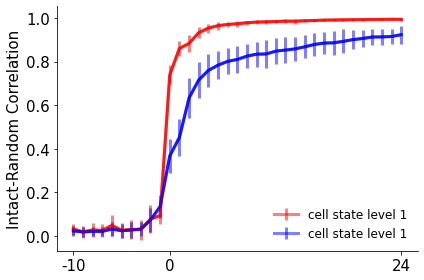

In [19]:
#Plot 
x_axis = range(VIEW_LENGTH)

plt.plot(x_axis, average2_corr_cell_l1, c='r',alpha=0.8,lw=3)
plt.errorbar(x_axis, average2_corr_cell_l1, yerr = np.std(average1_corr_cell_l1,0),
             c='r', alpha=0.5,label='cell state level 1',lw=3)

plt.plot(x_axis, average2_corr_cell_l2, c='b',alpha=0.8,lw=3)
plt.errorbar(x_axis, average2_corr_cell_l2, yerr = np.std(average1_corr_cell_l2,0),
             c='b', alpha=0.5,label='cell state level 1',lw=3)

plt.xticks([0, CONTEXT_LENGTH, VIEW_LENGTH-1], [-CONTEXT_LENGTH, 0, SHARED_LENGTH-1])

plt.ylabel("Intact-Random Correlation", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12,frameon=False)

plt.tight_layout()
plt.show()

## Fit logistic curves on number and syntax units

In [20]:
def CI(alpha, data):
    CI=stats.norm.interval(alpha, loc=np.mean(data), scale=stats.sem(data))
    
    return (CI[1]-CI[0])/2


from scipy.optimize import curve_fit
def curve_tanh(x,a,b,c):
    return a*np.tanh(b*x)
def curve_logistic(x,a,b,c,d):
    return (a-d)/(1+np.exp(-b*(x-c)))+d



def alignment_time(k,b,c):
    return(1/b)*np.log(k/(1-k))+c
def align_time_threshold(y,a,b,c,d):
    return np.log(a/(y-d)-1)/(-b)+c



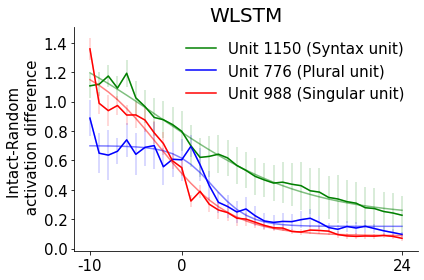

In [22]:
x_axis = range(VIEW_LENGTH)

xdata=np.arange(-CONTEXT_LENGTH,SHARED_LENGTH)

popt=[]
UNITS = [1149,775,987]
COLORS = ['g','b','r']

for i in range(len(UNITS)):
    unit = UNITS[i]
    c = COLORS[i]
    popt1,pcov=curve_fit(curve_logistic,xdata,average2_diff_cell[unit, :],maxfev=5000)
    if unit==1149:
        plt.plot(range(VIEW_LENGTH), average2_diff_cell[unit, :], color=c, label="Unit {} (Syntax unit)".format(unit+1))
    elif unit==775:
        plt.plot(range(VIEW_LENGTH), average2_diff_cell[unit, :], color=c, label="Unit {} (Plural unit)".format(unit+1))
    elif unit==987:
        plt.plot(range(VIEW_LENGTH), average2_diff_cell[unit, :], color=c, label="Unit {} (Singular unit)".format(unit+1))
    else:
        plt.plot(range(VIEW_LENGTH), average2_diff_cell[unit, :], color=c, label="Unit {}".format(unit))

    
    plt.errorbar(range(VIEW_LENGTH), average2_diff_cell[unit, :], CI(0.95,average1_diff_cell[:,unit, :]), color=c, alpha=0.2)    
    plt.plot(range(VIEW_LENGTH),curve_logistic(xdata, *popt1),color=c, alpha=0.5)
    plt.ylabel('Intact-Random \n activation difference', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    popt.append(popt1)
ax=plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('WLSTM',size=20)
 
plt.legend(fontsize=15,loc='upper right', bbox_to_anchor=(1, 1),frameon=False)
plt.xticks([0, CONTEXT_LENGTH, SHARED_LENGTH+CONTEXT_LENGTH-1], [-CONTEXT_LENGTH, 0, SHARED_LENGTH-1])

plt.tight_layout()
plt.show()

## Fit logistic curves and find the timescale for every unit

In [23]:
xdata=np.arange(-CONTEXT_LENGTH,SHARED_LENGTH)
total_cell,_=np.shape(average2_diff_cell)
asymptote1={}
construction_time1={}
no_fit=[]

import matplotlib.cm as cm

cmap = cm.cividis
for i in range(650,total_cell):
    try:
        popt1,pcov=curve_fit(curve_logistic,xdata,average2_diff_cell[i],maxfev=5000)
        mid=curve_logistic(xdata, *popt1)[CONTEXT_LENGTH]-((curve_logistic(xdata, *popt1)[CONTEXT_LENGTH]-(curve_logistic(xdata, *popt1)[-1]))/2)
        for j in range(len(curve_logistic(xdata, *popt1))-1):
            # time-to-half-maximum: see equation 2 in section 5 for details
            if curve_logistic(xdata, *popt1)[j]>mid and curve_logistic(xdata, *popt1)[j+1]<mid and j>CONTEXT_LENGTH-1:
                construction_time1[i]=j-CONTEXT_LENGTH
                color=(j-CONTEXT_LENGTH)/16
                
                plt.plot(range(SCALE),curve_logistic(xdata, *popt1), alpha=0.5,c=cm.cividis(color))
                plt.xticks([0, CONTEXT_LENGTH, SHARED_LENGTH+CONTEXT_LENGTH-1], [-CONTEXT_LENGTH, 0, SHARED_LENGTH-1],size=15)
                plt.yticks(size=15)
                plt.ylabel('Intact-Random \n activation difference', fontsize=15)
                ax=plt.gca()

                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

                asymptote1[i]=curve_logistic(xdata, *popt1)[5]
    except:
        no_fit.append(i)
        pass 

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [24]:
# Sort units based on their timescales
sorted_time=sorted(construction_time1.items(), key=lambda item: item[1],reverse=True)
sorted_cells=[]
sorted_timescale=[]
for i in sorted_time:
    sorted_cells.append(i[0])
    sorted_timescale.append(i[1])

## Heatmap view of all units' activation 

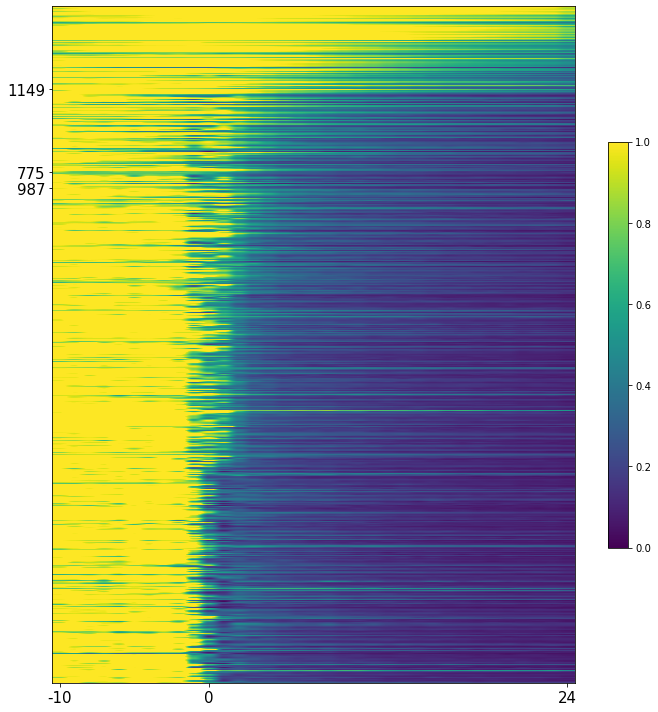

In [25]:
interested_cells=[775,987, 1149]
pos=[]
cell_pos=[]

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
poss=ax1.imshow(average2_diff_cell[sorted_cells],aspect="auto",vmin=0, vmax=1)
for i in range(len(sorted_cells)):
    if sorted_cells[i] in interested_cells:
        pos.append(i)
        cell_pos.append(sorted_cells[i])
ax1.set_yticks(pos) 
ax1.set_yticklabels(cell_pos,size=15) 
ax1.set_xticks([0, CONTEXT_LENGTH, SHARED_LENGTH+CONTEXT_LENGTH-1])
ax1.set_xticklabels([-CONTEXT_LENGTH, 0, SHARED_LENGTH-1], size=15)

fig.colorbar(poss, shrink=0.6)

plt.tight_layout()
plt.show()

## Connectivity Analyses

In [26]:
#Load hidden-gate projection w_hi, w_hf, w_hc, w_ho
w_hi=model_pretrained.rnn.weight_hh_l1[:650]
w_hf=model_pretrained.rnn.weight_hh_l1[650:650*2]
w_hc=model_pretrained.rnn.weight_hh_l1[650*2:650*3]
w_ho=model_pretrained.rnn.weight_hh_l1[650*3:650*4]

In [27]:
w_hf_hi=torch.cat((w_hf,w_hi),0)

### Significant Projection

In [28]:
def significant_weight_connection(weight_hidden2gate):
    sig_conn_all=[]
    sig_conn_number=[]
    z_connection=np.zeros((650,650))
    for from_cell in range(650):
        sig_conn=[]
        for to_cell in range(650):
            z = (weight_hidden2gate[to_cell,from_cell]-weight_hidden2gate[:,from_cell].mean())/weight_hidden2gate[:,from_cell].std()
            z_connection[from_cell][to_cell]=abs(z)
            
            if abs(z)>5:
                sig_conn.append(to_cell+650)
        sig_conn_all.append(sig_conn)
        sig_conn_number.append(len(sig_conn))
    return sig_conn_all, sig_conn_number,z_connection

In [29]:
# Get significant connections to input/forget gate
sig_conn_all_whf, sig_conn_number_whf, z_whf=significant_weight_connection(w_hf)
sorted_sig_conn_number_whf=[]
for i in sorted_cells:
    sorted_sig_conn_number_whf.append(sig_conn_number_whf[i-650])

sig_conn_all_whi, sig_conn_number_whi, z_whi=significant_weight_connection(w_hi)
sorted_sig_conn_number_whi=[]
for i in sorted_cells:
    sorted_sig_conn_number_whi.append(sig_conn_number_whi[i-650])

### Significantly projected cells from syntax unit (1150)

[]

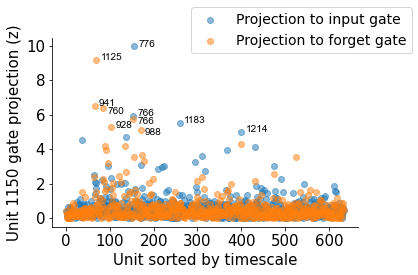

In [30]:
z_whf_sorted=np.zeros((len(sorted_cells),len(sorted_cells)))
z_whi_sorted=np.zeros((len(sorted_cells),len(sorted_cells)))

for i in range(len(sorted_cells)):
    for j in range(len(sorted_cells)):
        z_whf_sorted[i][j]=z_whf[sorted_cells[i]-650][sorted_cells[j]-650]
        z_whi_sorted[i][j]=z_whi[sorted_cells[i]-650][sorted_cells[j]-650]
        
unit=1149
plt.scatter(np.arange(len(z_whi_sorted)),z_whi_sorted[sorted_cells.index(unit)],label='Projection to input gate',alpha=0.5)
plt.scatter(np.arange(len(z_whf_sorted)),z_whf_sorted[sorted_cells.index(unit)],label='Projection to forget gate',alpha=0.5)

for i in range(len(sorted_cells)):
    if abs(z_whi_sorted[sorted_cells.index(unit),i])>5:
        plt.text(i+10,z_whi_sorted[sorted_cells.index(unit),i],'%d'%(sorted_cells[i]+1),size=10,fontname='Arial')
    if abs(z_whf_sorted[[sorted_cells.index(unit)],i])>5:
        if sorted_cells[i]+1==760 or sorted_cells[i]+1==766 or sorted_cells[i]+1==988:
            plt.text(i+10,z_whf_sorted[sorted_cells.index(unit),i]-0.3,'%d'%(sorted_cells[i]+1),size=10,fontname='Arial')
        else:
            plt.text(i+10,z_whf_sorted[sorted_cells.index(unit),i],'%d'%(sorted_cells[i]+1),size=10,fontname='Arial')

plt.ylabel('Unit 1150 gate projection (z)', size=15)
plt.xlabel('Unit sorted by timescale', size=15)
plt.xticks(size=15)
plt.yticks(size=15)

ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=14,loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.tight_layout()

plt.plot()

### K-core Analysis

In [31]:
import networkx as nx

def node_color(graph):
    node_color=[]
    for i in graph.nodes():
        if i+650 in sorted_cells:
            node_color.append(sorted_times[sorted_cells.index(i+650)][1])
        else:
            node_color.append(0)

    node_color_normalize=[0]*len(node_color)
    for i in range(len(node_color)):
        node_color_normalize[i]=round((node_color[i]-min(node_color))/(max(node_color)-min(node_color)),1)
    return node_color_normalize

def insert_edges_by_sig_conn(graph, sig_conn):
    for i in range(len(sig_conn)):
        for j in range(len(sig_conn[i])):
            if i!=sig_conn[i][j]-650:
                graph.add_edge(i,sig_conn[i][j]-650)

In [32]:
#Assign color scale of each unit by timescale
node_color=[]
for i in range(650):
    if i+650 in sorted_cells:
        node_color.append(sorted_timescale[sorted_cells.index(i+650)])
    else:
        node_color.append(0)

node_color_normalize=[0]*len(node_color)
for i in range(len(node_color)):
    node_color_normalize[i]=round((node_color[i]-min(node_color))/(10-min(node_color)),1)

In [33]:
sig_conn_all_whihf = []
for i in range(len(sig_conn_all_whi)):
    sig_conn_all_whihf.append(sig_conn_all_whf[i]+sig_conn_all_whi[i])

#construct network by significant projections from hidden units to input gate + forget gate (i.e. |z|>5)
G=nx.DiGraph() 
insert_edges_by_sig_conn(G, sig_conn_all_whihf) 

#find k projections from hidden units to input gate + forget gate in the weight matrices
w_hf_hi_numpy=np.swapaxes(w_hf_hi.detach().numpy(),0,1)
w_hf_hi_flatten=w_hf_hi_numpy.flatten()
w_hf_hi_flatten_sort=np.argsort(abs(w_hf_hi_flatten))[::-1]

from_unit=[]
to_unit=[]
i=0

while i < len(G.edges()):
    fu = w_hf_hi_flatten_sort[i]//1300
    tu = w_hf_hi_flatten_sort[i]%1300
    if tu > 649:
        tu -= 650
    if tu!=fu:
        from_unit.append(fu)
        to_unit.append(tu)
    i+=1
    
edges=[]
for i in range(len(to_unit)):
    edges.append((from_unit[i],to_unit[i]))
    
#construct network by the top k projections from hidden units to input gate + forget gate in the weight matrices
G2=nx.DiGraph()
G2.add_edges_from(edges)
k_core_G_Whfhi2 = nx.algorithms.core.k_core(G2, k=None, core_number=None)

k_core_G_Whfhi2_net=dict(k_core_G_Whfhi2.degree)
degree={}
for i in k_core_G_Whfhi2_net.keys():
    degree[i+650]=k_core_G_Whfhi2.degree()[i]

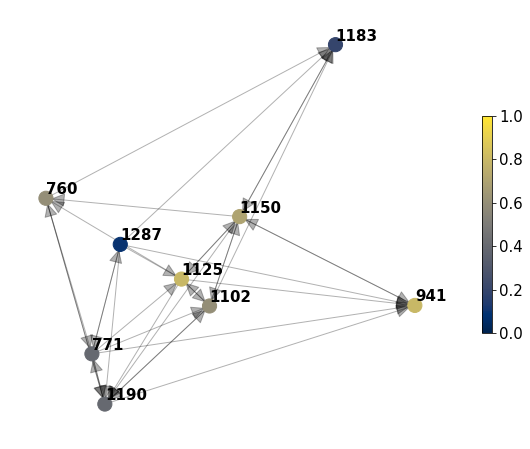

In [34]:
import matplotlib.cm as cm
core_units2=k_core_G_Whfhi2.nodes()

core_node_color2=[]
for i in core_units2:
    core_node_color2.append(node_color_normalize[i])


cmap = cm.cividis
plt.figure(figsize=(10,8))
pos=nx.spring_layout(k_core_G_Whfhi2)

nodes=nx.draw_networkx(k_core_G_Whfhi2,pos,node_size=100, cmap = cmap,with_labels=False,node_color=core_node_color2,alpha=0.3,arrowsize=30)


nx.draw_networkx_nodes(k_core_G_Whfhi2,pos, nodelist=None, node_size=200, cmap = cmap, node_color=core_node_color2,node_shape='o',vmax=1,vmin=0)

for i in k_core_G_Whfhi2.nodes():
    x,y=pos[i]
    plt.text(x,y+0.02,s=i+651, size=15,weight='bold')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])


cbar = plt.colorbar(sm, shrink=0.5)
cbar.ax.tick_params(labelsize=15) 

plt.axis('off')

plt.show()

In [36]:
#integrator units = units with the top 10 longest timescales and in the center of MDS
integrator=[]
for i in range(13):
    if sorted_cells[i] not in [731, 1248, 675]: #these three units are not in the center of MDS
        integrator.append(sorted_cells[i])

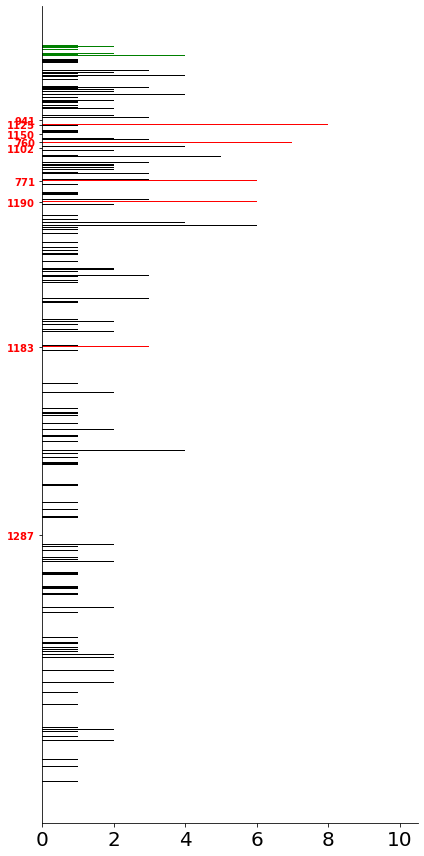

In [37]:
sorted_sig_conn_number_whfhi=[sum(x) for x in zip(sorted_sig_conn_number_whf, sorted_sig_conn_number_whi)]

fig, ax = plt.subplots(figsize=(6,12))

# Example data
cell = sorted_cells
y_pos = np.arange(len(sorted_cells))
strength = sorted_sig_conn_number_whfhi
colors=['g']*13+['k']*(len(sorted_sig_conn_number_whfhi)-13) #timescales longer than the units in the core are defined as integrator units
for i in core_units2:
    colors[cell.index(i+650)]='r'
ax.barh(y_pos, strength, align='center',color=colors)

ax.invert_yaxis()  # labels read top-to-bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos=[]
cell_pos=[]

for i in range(len(sorted_cells)):
    if sorted_cells[i]-650 in core_units2:
        pos.append(i)
        cell_pos.append(sorted_cells[i]+1)
plt.xticks(size=20)
plt.yticks([])
ax.set_yticks(pos)
ax.set_yticklabels(cell_pos,size=10,weight='bold',color='r') 

plt.tight_layout()

plt.show()

### MDS plot

In [38]:
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

w_hf_hi_reshape=np.swapaxes(w_hf_hi.detach().numpy(),0,1)
w_hf_hi_sim = euclidean_distances(w_hf_hi_reshape)

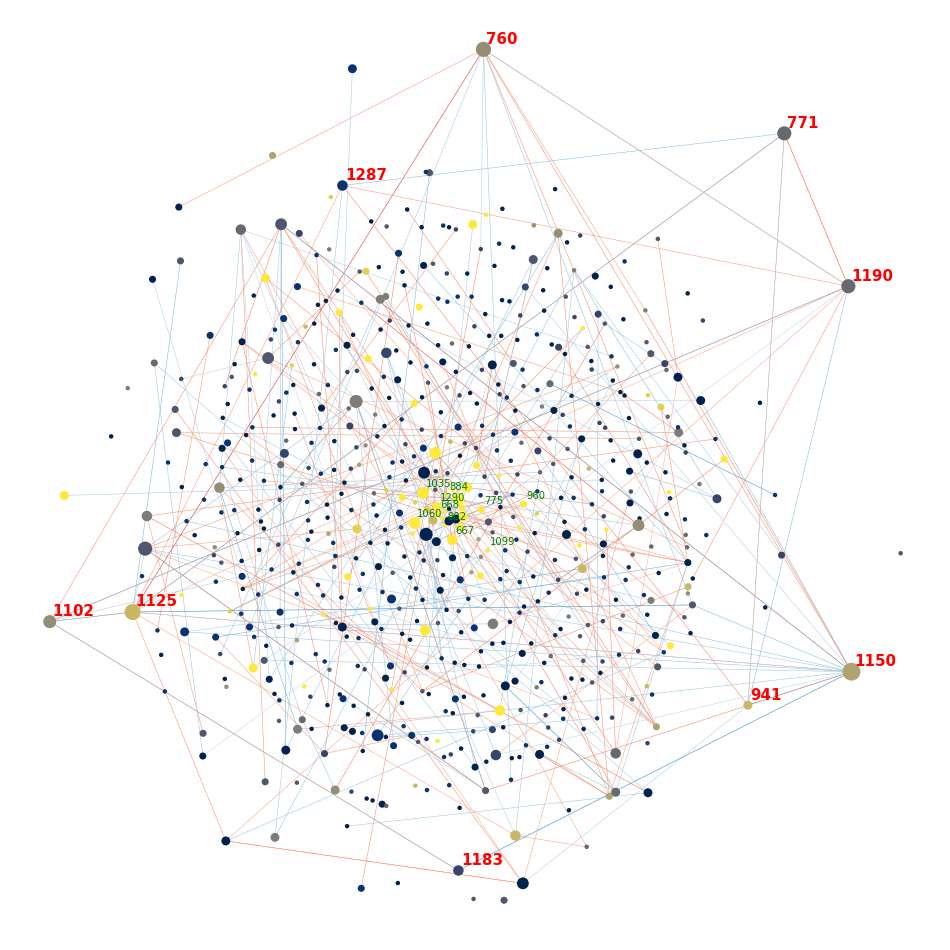

In [40]:
sig_conn_hihf=[sum(x) for x in zip(sig_conn_number_whi, sig_conn_number_whf)]

seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
poss = mds.fit(w_hf_hi_sim).embedding_


# Rotate the data
clf = PCA(n_components=2)

poss = clf.fit_transform(poss)


fig = plt.figure(figsize=(13,13))
ax = plt.axes([0., 0., 1., 1.])

cmap = cm.cividis
s_arr=[x*30+20 for x in sig_conn_hihf]

plt.scatter(poss[:, 0], poss[:, 1], c=node_color_normalize, s=s_arr,cmap=cmap,lw=0,vmin=0,vmax=1)

for unit in core_units2:
    plt.text(poss[unit,0]+0.1,poss[unit,1]+0.2,s=str(unit+651), size=15,weight='bold',c='r')
    
for unit in integrator:
    plt.text(poss[unit-650,0]+0.1,poss[unit-650,1]+0.2,s=str(unit+1), c='g',size=10)
    

segments = [[poss[i, :], poss[j-650, :]]
            for i in range(len(poss)) for j in sig_conn_all_whf[i]]

segments2 = [[poss[i, :], poss[j-650, :]]
            for i in range(len(poss)) for j in sig_conn_all_whi[i]]


lc = LineCollection(segments,zorder=0, cmap=plt.cm.Reds, label='forget gate connection')
lc2 = LineCollection(segments2,zorder=0, cmap=plt.cm.Blues, label='input gate connection')

lc.set_array(w_hf_hi_sim.flatten())
lc2.set_array(w_hf_hi_sim.flatten())

lc.set_linewidths(np.full(len(segments), 0.5))
lc2.set_linewidths(np.full(len(segments2), 0.5))

ax.add_collection(lc)
ax.add_collection(lc2)

plt.axis('off')
plt.tight_layout()
plt.show()